<a href="https://colab.research.google.com/github/mdsiam135/STI_2025/blob/main/Transformer(3_Labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
# Transformer for Crop Production Classification (3 Classes - Quantile Based)

# This script demonstrates how to build and train a Transformer model
# for classifying crop production levels based on tabular data using TensorFlow/Keras.
# Uses quantile-based 3 classes (Low, Medium, High) for balanced distribution.
# Enhanced with validation classification report, confusion matrix, and macro F1 score.

## 1. Setup and Imports

# Import necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (optional, if data is stored there)
# from google.colab import drive
# drive.mount("/content/drive")

# Define file paths (adjust if using Google Drive or local upload)
# Example for uploaded files in Colab:
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/train.csv"
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validation.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/test.csv"


In [2]:

## 2. Quantile Calculation and Data Preprocessing

def calculate_quantile_bins(train_file_path):
    """Calculate quantile-based bins from training data only."""
    df_train = pd.read_csv(train_file_path)
    production_values = df_train["Production (M.Ton)"]

    # Calculate 33rd and 66th percentiles for 3 equal classes
    q33 = production_values.quantile(0.33)
    q66 = production_values.quantile(0.66)

    bins = [-np.inf, q33, q66, np.inf]
    print(f"Quantile-based bins:")
    print(f"  Low: < {q33:.2f}")
    print(f"  Medium: {q33:.2f} - {q66:.2f}")
    print(f"  High: > {q66:.2f}")

    return bins

# Load and preprocess data using quantile-based classification
def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False, bins=None):
    """Loads data, preprocesses features, and converts target to classes using quantile bins."""
    df = pd.read_csv(file_path)

    # Use provided bins (calculated from training data)
    if bins is None:
        raise ValueError("Bins must be provided for consistent classification across train/val/test")

    labels = [0, 1, 2]  # Low, Medium, High

    # Convert target variable to classes using quantile-based bins
    df["Production_Class"] = pd.cut(df["Production (M.Ton)"], bins=bins, labels=labels, right=True)

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Class"], axis=1)
    y = df["Production_Class"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        X[numerical_cols] = scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # Return features as a flat numpy array (samples, features)
    X_flat = X.values

    if fit_scaler and fit_encoder:
        return X_flat, y_one_hot, scaler, label_encoder
    elif fit_scaler:
         return X_flat, y_one_hot, scaler
    elif fit_encoder:
        return X_flat, y_one_hot, label_encoder
    else:
        return X_flat, y_one_hot

# Calculate quantile bins from training data only
print("Calculating quantile-based bins from training data...")
quantile_bins = calculate_quantile_bins(TRAIN_PATH)

# Load and preprocess data using the calculated bins
print("\nLoading and preprocessing training data...")
X_train, y_train, scaler, label_encoder = load_and_preprocess(
    TRAIN_PATH, fit_scaler=True, fit_encoder=True, bins=quantile_bins
)

print("Loading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(
    VALID_PATH, scaler=scaler, label_encoder=label_encoder, bins=quantile_bins
)

print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(
    TEST_PATH, scaler=scaler, label_encoder=label_encoder, bins=quantile_bins
)

print(f"\nTraining data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")

# Check class distribution in training data
train_labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(train_labels, return_counts=True)
class_names = ["Low", "Medium", "High"]
print("\nTraining data class distribution:")
for i, (label, count) in enumerate(zip(unique, counts)):
    percentage = (count / len(train_labels)) * 100
    print(f"  {class_names[label]}: {count} samples ({percentage:.1f}%)")


Calculating quantile-based bins from training data...
Quantile-based bins:
  Low: < 1071.56
  Medium: 1071.56 - 3900.19
  High: > 3900.19

Loading and preprocessing training data...
Loading and preprocessing validation data...
Loading and preprocessing test data...

Training data shape: (3942, 83), Labels shape: (3942, 3)
Validation data shape: (845, 83), Labels shape: (845, 3)
Test data shape: (845, 83), Labels shape: (845, 3)
Number of classes: 3

Training data class distribution:
  Low: 1301 samples (33.0%)
  Medium: 1301 samples (33.0%)
  High: 1340 samples (34.0%)


In [3]:

## 3. Build the Transformer Model

# Define the Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Corrected call method: pass 'training' argument to sub-layers
    def call(self, inputs, training=None): # Allow training=None for inference
        # Pass training argument to MultiHeadAttention
        attn_output = self.att(inputs, inputs, training=training)
        # Pass training argument to Dropout 1
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Pass training argument to the Sequential FFN
        ffn_output = self.ffn(out1, training=training)
        # Pass training argument to Dropout 2
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer model building function
def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout_rate=0.1):
    """Builds the Transformer model for tabular data."""
    num_features = input_shape[0]
    inputs = keras.Input(shape=input_shape)

    # --- Feature Embedding and Positional Encoding ---
    # Project features to embedding dimension
    x = layers.Dense(num_features * embed_dim, activation='relu')(inputs) # Project
    x = layers.Reshape((num_features, embed_dim))(x) # Reshape to (batch, seq_len=num_features, embed_dim)

    # Add learnable positional embedding
    position_embedding_layer = layers.Embedding(input_dim=num_features, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_features, delta=1)
    position_embeddings = position_embedding_layer(positions)
    x = x + position_embeddings
    # Pass training argument to Dropout after embedding
    x = layers.Dropout(dropout_rate)(x) # Keras handles training arg here implicitly in functional API
    # ----------------------------------------------------

    # --- Transformer Blocks ---
    for _ in range(num_transformer_blocks):
        # Keras handles passing the 'training' context implicitly here in functional API
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    # -------------------------

    # --- Classifier Head ---
    x = layers.GlobalAveragePooling1D()(x) # Pool across the feature dimension
    # Pass training argument to Dropout layers
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    # -----------------------

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Hyperparameters ---
EMBED_DIM = 32  # Embedding dimension for each feature position
NUM_HEADS = 4   # Number of attention heads
FF_DIM = 32     # Hidden layer size in feed forward network inside transformer
NUM_TRANSFORMER_BLOCKS = 2 # Number of transformer blocks
DROPOUT_RATE = 0.1
# -----------------------

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1],) # Shape is (num_features,)
num_classes = y_train.shape[1]  # Now 3 classes

# Build the model
model = build_transformer_model(
    input_shape,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
)

# Compile the model
# Consider using AdamW or a lower learning rate for Transformers
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2656)           │       223,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 83, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 83, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,491 (1.01 MB)

 Trainable params: 263,491 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

## 4. Train the Model

# Train the Transformer using the training and validation datasets.

# Define training parameters
EPOCHS = 100 # Transformers might need more epochs, adjust as needed
BATCH_SIZE = 64

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True) # Increased patience

# Train the model
print("\nStarting model training...")
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)



Starting model training...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.3843 - loss: 1.0966 - val_accuracy: 0.5456 - val_loss: 0.9973
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.5621 - loss: 0.9758 - val_accuracy: 0.7006 - val_loss: 0.8071
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.6988 - loss: 0.7784 - val_accuracy: 0.7645 - val_loss: 0.6050
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 297ms/step - accuracy: 0.7834 - loss: 0.5689 - val_accuracy: 0.8000 - val_loss: 0.5095
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.8281 - loss: 0.4661 - val_accuracy: 0.8272 - val_loss: 0.4543
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.8419 - loss: 0.4153 - val_accuracy: 0.8296 - val_loss: 0.4278
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.8691 - loss: 0.3554 - val_accuracy: 0.8462 - val_loss: 0.3991
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accura

In [5]:

## 5. Evaluate the Model on Validation Set

# Get best validation accuracy from history
# Check if 'val_accuracy' exists in history (it should if validation_data is provided)
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")

# Evaluate the trained model on the validation dataset first
print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)

print("\nEvaluating model on validation data...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions on validation set
print("\nGenerating predictions on validation data...")
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Convert one-hot encoded y_val back to single labels for comparison
y_val_labels = np.argmax(y_val, axis=1)

# Print Validation Classification Report
print("\nValidation Classification Report (includes Recall and F1-score):")
print(classification_report(y_val_labels, y_val_pred, target_names=class_names))

# Calculate and print Validation Macro F1 Score
val_macro_f1 = f1_score(y_val_labels, y_val_pred, average='macro')
print(f"\nMacro F1 Score (Validation Set): {val_macro_f1:.4f}")

# Print Validation Confusion Matrix
print("\nValidation Confusion Matrix:")
val_cm = confusion_matrix(y_val_labels, y_val_pred)
print(val_cm)

# Check validation class distribution
unique_val, counts_val = np.unique(y_val_labels, return_counts=True)
print("\nValidation data class distribution:")
for i, (label, count) in enumerate(zip(unique_val, counts_val)):
    percentage = (count / len(y_val_labels)) * 100
    print(f"  {class_names[label]}: {count} samples ({percentage:.1f}%)")



Best Validation Accuracy: 0.9231

VALIDATION SET EVALUATION

Evaluating model on validation data...
Validation Loss: 0.2847
Validation Accuracy: 0.9065

Generating predictions on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step

Validation Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

         Low       0.93      0.94      0.94       278
      Medium       0.85      0.88      0.87       290
        High       0.94      0.90      0.92       277

    accuracy                           0.91       845
   macro avg       0.91      0.91      0.91       845
weighted avg       0.91      0.91      0.91       845


Macro F1 Score (Validation Set): 0.9074

Validation Confusion Matrix:
[[261  17   0]
 [ 19 256  15]
 [  0  28 249]]

Validation data class distribution:
  Low: 278 samples (32.9%)
  Medium: 290 samples (34.3%)
  High: 277 samples (32.8%)


In [6]:

## 6. Evaluate the Model on Test Set

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Evaluate the trained model on the test dataset.
print("\nEvaluating model on test data...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions on test set
print("\nGenerating predictions on test data...")
y_test_pred_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Convert one-hot encoded y_test back to single labels for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Print Test Classification Report
print("\nTest Classification Report (includes Recall and F1-score):")
print(classification_report(y_test_labels, y_test_pred, target_names=class_names))

# Calculate and print Test Macro F1 Score
test_macro_f1 = f1_score(y_test_labels, y_test_pred, average='macro')
print(f"\nMacro F1 Score (Test Set): {test_macro_f1:.4f}")

# Print Test Confusion Matrix
print("\nTest Confusion Matrix:")
test_cm = confusion_matrix(y_test_labels, y_test_pred)
print(test_cm)

# Check test class distribution
unique_test, counts_test = np.unique(y_test_labels, return_counts=True)
print("\nTest data class distribution:")
for i, (label, count) in enumerate(zip(unique_test, counts_test)):
    percentage = (count / len(y_test_labels)) * 100
    print(f"  {class_names[label]}: {count} samples ({percentage:.1f}%)")



TEST SET EVALUATION

Evaluating model on test data...
Test Loss: 0.2421
Test Accuracy: 0.9160

Generating predictions on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

Test Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

         Low       0.94      0.96      0.95       274
      Medium       0.86      0.88      0.87       269
        High       0.95      0.91      0.93       302

    accuracy                           0.92       845
   macro avg       0.92      0.92      0.92       845
weighted avg       0.92      0.92      0.92       845


Macro F1 Score (Test Set): 0.9153

Test Confusion Matrix:
[[263  11   0]
 [ 18 236  15]
 [  0  27 275]]

Test data class distribution:
  Low: 274 samples (32.4%)
  Medium: 269 samples (31.8%)
  High: 302 samples (35.7%)


Text(0.5, 0, 'Epoch')

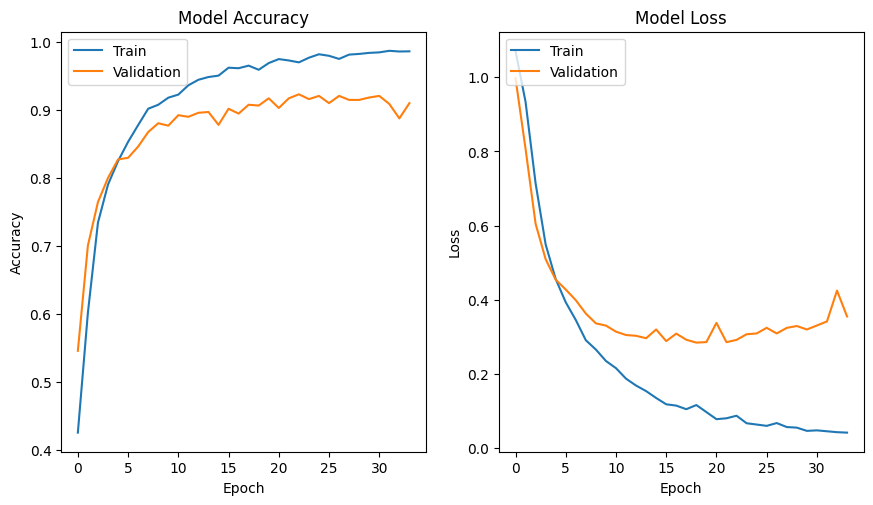

In [7]:

## 7. Visualize Results

# Plot training history and confusion matrices.

# Create a larger figure for all visualizations
plt.figure(figsize=(16, 12))

# Plot training & validation accuracy values
plt.subplot(2, 3, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history:
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# Plot training & validation loss values
plt.subplot(2, 3, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history:
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")


Text(0.5, 3.722222222222216, 'Predicted Label')

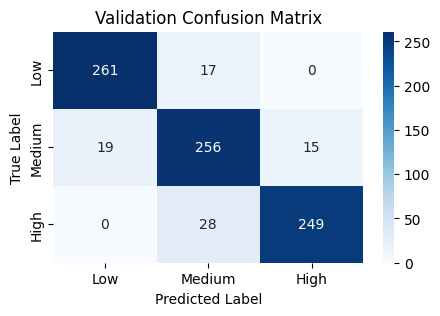

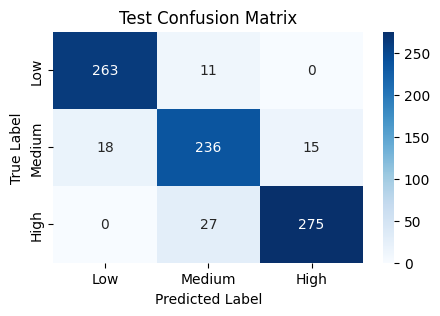

In [8]:

# Plot Validation Confusion Matrix Heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Validation Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Plot Test Confusion Matrix Heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Test Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")




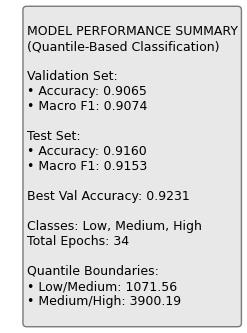

In [9]:

# Summary text box
plt.subplot(2, 3, 6)
plt.axis('off')
summary_text = f"""
MODEL PERFORMANCE SUMMARY
(Quantile-Based Classification)

Validation Set:
• Accuracy: {val_accuracy:.4f}
• Macro F1: {val_macro_f1:.4f}

Test Set:
• Accuracy: {test_accuracy:.4f}
• Macro F1: {test_macro_f1:.4f}

Best Val Accuracy: {best_val_accuracy:.4f}

Classes: {', '.join(class_names)}
Total Epochs: {len(history.history['loss'])}

Quantile Boundaries:
• Low/Medium: {quantile_bins[1]:.2f}
• Medium/High: {quantile_bins[2]:.2f}
"""
plt.text(0.1, 0.5, summary_text, transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()


In [10]:

## 8. Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY - QUANTILE-BASED CLASSIFICATION")
print("="*60)
print(f"Quantile Boundaries:")
print(f"  Low/Medium threshold: {quantile_bins[1]:.2f}")
print(f"  Medium/High threshold: {quantile_bins[2]:.2f}")
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print("="*60)

print("\n--- End of Script ---")


FINAL SUMMARY - QUANTILE-BASED CLASSIFICATION
Quantile Boundaries:
  Low/Medium threshold: 1071.56
  Medium/High threshold: 3900.19

Best Validation Accuracy: 0.9231
Validation Macro F1 Score: 0.9074
Test Accuracy: 0.9160
Test Macro F1 Score: 0.9153

--- End of Script ---
